# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns

## Alunos: Breno Cauã Batista Prestes e Mizael Simão

### Contexto

No Airbnb, qualquer pessoa que possua um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### Base de dados

Baixar as bases de dados do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- A sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Etapas previstas do Projeto (metodologia CRISP)
- Definição do Problema
- Entendimento e ajuste (limpeza) dos dados
- Análise Exploratória,  analisar os Outliers
- Tratamento dos dados
- Definição do algoritmo de aprendizagem de máquina
- Validação do modelo
- Apresentação dos dados
- Modelo em produção

### Importar Bibliotecas e Bases de Dados

- Iniciaremos fazendo o importe das bibliotecas iniciais necessárias para realizar a carga da base de dados. Se o bloco abaixo der erro no seu computador, pesquise pelo programa "prompt Anaconda" e execute os seguintes códigos de instalação:
    - pip install seaborn
    - pip install plotly

### Etapa de Limpeza e ajuste dos dados:
Importem as bibliotecas: pandas, pathlib, numpy, matplotlib, seaborn, pltly.express, sklearn.metrics, skleanr.linear_model, sklearn.ensemble e sklearn.model_selection

In [ ]:
import os
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

### Importar as bases de dados

- Para cada arquivo da base de dados importado, adicione duas colunas na base de dados uma para o mês e outra para o ano.

- Adicione cada arquivo lido na base_airbnb

- Utilize a biblioteca pathlib.Path para definir o caminho de identificação da base

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataframes = []

dir = Path('/content/drive/MyDrive/Colab Notebooks/archive')
files = list(dir.glob('*.csv'))

for file in files:
    file_title = file.stem
    match = re.match(r"([a-zA-Z]+)(\d+)", file_title)
    month = ''
    year= ''

    if match:
        month = match.group(1)
        year = match.group(2)

    df = []
    df = pd.read_csv(file, low_memory=False)
    df['month'] = month
    df['year'] = year
    dataframes.append(df)

base_airbnb = pd.concat(dataframes, ignore_index=True)

### Agora vamos começar os tratamentos de dados

- Como temos muitas colunas, nosso modelo pode acabar ficando muito lento.
- Além disso, uma análise rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão, por isso, vamos excluir algumas colunas da base
- Tipos de colunas que vamos excluir:
    1. IDs, Links e informações não relevantes para o modelo
    2. Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex: Data x Ano/Mês (mantenham o Ano/Mês que foram adicionados a base
    3. Colunas preenchidas com texto livre -> Não rodaremos nenhuma análise de palavras ou algo do tipo
    4. Colunas em que todos ou quase todos os valores são iguais
- Ao final visualize a base de dados

In [ ]:
# Excluir colunas desnecessárias

# Excluindo colunas de URL's
base_airbnb = base_airbnb.drop(['listing_url', 'thumbnail_url', 'picture_url', 'host_url', 'host_thumbnail_url',
                                'xl_picture_url', 'medium_url', 'host_picture_url'], axis=1)

# Excluindo colunas com IDs
base_airbnb = base_airbnb.drop(['id','scrape_id', 'host_id'], axis=1)

# Excluindo colunas texto livre
base_airbnb = base_airbnb.drop(['name', 'summary', 'description', 'notes', 'last_scraped', 'host_name',
                                'city', 'country', 'host_response_time', 'smart_location'], axis=1)

# Excluindo colunas parecidas, datas, etc.
base_airbnb = base_airbnb.drop(['host_since', 'calendar_updated', 'requires_license', 'license', 'house_rules', 'host_location',
                               'neighborhood_overview', 'access', 'transit', 'calendar_last_scraped'], axis=1)

base_airbnb = base_airbnb.drop(['require_guest_profile_picture', 'require_guest_phone_verification', 'availability_365',
                                'amenities', 'is_location_exact', 'country_code'], axis=1)

base_airbnb = base_airbnb.drop(['experiences_offered', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic',
                                'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'zipcode', 'market'], axis=1)

base_airbnb = base_airbnb.drop(['has_availability', 'availability_30', 'availability_60', 'availability_90', 'instant_bookable',
                               'cancellation_policy', 'is_business_travel_ready', 'state', 'host_total_listings_count'], axis=1)

display(df)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,month,year
0,17878,https://www.airbnb.com/rooms/17878,20190923212307,2019-09-24,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for Carni...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for Carni...,none,This is the best spot in Rio. Everything happe...,...,strict_14_with_grace_period,f,f,1,1,0,0,2.13,setembro,2019
1,25026,https://www.airbnb.com/rooms/25026,20190923212307,2019-09-24,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,strict_14_with_grace_period,t,t,3,3,0,0,2.06,setembro,2019
2,31560,https://www.airbnb.com/rooms/31560,20190923212307,2019-09-24,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,strict_14_with_grace_period,f,f,1,1,0,0,2.36,setembro,2019
3,35636,https://www.airbnb.com/rooms/35636,20190923212307,2019-09-24,Cosy flat close to Ipanema beach,This cosy apartment is just a few steps away ...,"The location is extremely convenient, safe and...",This cosy apartment is just a few steps away ...,none,The apartment street is very quiet and safe ....,...,strict_14_with_grace_period,t,t,1,1,0,0,2.25,setembro,2019
4,35764,https://www.airbnb.com/rooms/35764,20190923212307,2019-09-24,COPACABANA SEA BREEZE - RIO - 20 X Superhost,Our newly renovated studio is located in the b...,"FEEL LIKE YOUR HOME LIVING AS ""CARIOCA"" LOCAL ...",Our newly renovated studio is located in the b...,none,Our guests will experience living with a local...,...,strict_14_with_grace_period,f,t,1,1,0,0,2.83,setembro,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,38844730,https://www.airbnb.com/rooms/38844730,20190923212307,2019-09-24,TRANSAMERICA BARRA DA TIJUCA R IV,"Em estilo contemporâneo, o Transamerica Prime ...",NaN,"Em estilo contemporâneo, o Transamerica Prime ...",none,NaN,...,flexible,f,f,15,15,0,0,NaN,setembro,2019
34325,38846408,https://www.airbnb.com/rooms/38846408,20190923212307,2019-09-24,Alugo para o Rock in Rio,"Confortável apartamento, 2 quartos , sendo 1 s...",O apartamento estará com mobília completa disp...,"Confortável apartamento, 2 quartos , sendo 1 s...",none,"Muito próximo ao Parque Olímpico, local do eve...",...,flexible,f,f,1,1,0,0,NaN,setembro,2019
34326,38846703,https://www.airbnb.com/rooms/38846703,20190923212307,2019-09-24,Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA,Apartamento quarto e sala COMPLETO para curtas...,Espaço ideal para até 5 pessoas. Cama de casal...,Apartamento quarto e sala COMPLETO para curtas...,none,NaN,...,strict_14_with_grace_period,f,f,29,23,6,0,NaN,setembro,2019
34327,38847050,https://www.airbnb.com/rooms/38847050,20190923212307,2019-09-24,Cobertura Cinematografica,Cobertura alto nivel,NaN,Cobertura alto nivel,none,NaN,...,strict_14_with_grace_period,f,f,1,1,0,0,NaN,setembro,2019


### Tratar Valores Faltando

- Visualizando os dados, percebemos que existe uma grande disparidade em dados faltantes. As colunas com mais de 300.000 valores NaN devem ser excluídas
- Para as outras colunas, como temos muitos dados (mais de 900.000 linhas) vamos excluir as linhas que contém dados NaN

In [ ]:
# Contando o número de valores NaN em cada coluna
nan_counts = base_airbnb.isna().sum()

# Selecionando colunas com mais de 300.000 NaNs
columns_to_drop = nan_counts[nan_counts > 300000].index

# Excluindo essas colunas
base_airbnb = base_airbnb.drop(columns=columns_to_drop)
base_airbnb = base_airbnb.dropna()

### Verificar Tipos de Dados em cada coluna

- Precisamos fazer isso porque às vezes o Python está lendo como texto alguma coluna que deveria ser um número, então precisamos corrigir

In [ ]:
base_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 897709 entries, 0 to 902209
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   host_listings_count             897709 non-null  float64
 1   latitude                        897709 non-null  float64
 2   longitude                       897709 non-null  float64
 3   property_type                   897709 non-null  object 
 4   room_type                       897709 non-null  object 
 5   accommodates                    897709 non-null  int64  
 6   bathrooms                       897709 non-null  float64
 7   bedrooms                        897709 non-null  float64
 8   beds                            897709 non-null  float64
 9   bed_type                        897709 non-null  object 
 10  price                           897709 non-null  object 
 11  guests_included                 897709 non-null  int64  
 12  extra_people         

- Como preço e extra people estão sendo reconhecidos como objeto (ao invés de ser um float) temos que mudar o tipo de variável da coluna.

In [ ]:
# Remover o símbolo de dólar e espaços extras
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '').str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '').str.replace(',', '')

# Convertendo as colunas para tipo float
base_airbnb['price'] = base_airbnb['price'].astype(float)
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(float)

In [ ]:
base_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 897709 entries, 0 to 902209
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   host_listings_count             897709 non-null  float64
 1   latitude                        897709 non-null  float64
 2   longitude                       897709 non-null  float64
 3   property_type                   897709 non-null  object 
 4   room_type                       897709 non-null  object 
 5   accommodates                    897709 non-null  int64  
 6   bathrooms                       897709 non-null  float64
 7   bedrooms                        897709 non-null  float64
 8   beds                            897709 non-null  float64
 9   bed_type                        897709 non-null  object 
 10  price                           897709 non-null  float64
 11  guests_included                 897709 non-null  int64  
 12  extra_people         

### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

### Análise Exploratória

In [ ]:
# Contando a quantidade de valores nulos
base_airbnb.isnull().sum()

,0
host_listings_count,0
latitude,0
longitude,0
property_type,0
room_type,0
accommodates,0
bathrooms,0
bedrooms,0
beds,0
bed_type,0


In [ ]:
# Verificando as informações estatísticas da base
base_airbnb.describe()

,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,calculated_host_listings_count
count,897709.000000,897709.000000,897709.000000,897709.000000,897709.000000,897709.000000,897709.000000,897709.000000,897709.000000,897709.000000,897709.000000,8.977090e+05,897709.000000,897709.000000
mean,8.540508,-22.965346,-43.253856,4.211794,1.695061,1.645698,2.601979,647.922333,1.677594,40.158717,4.559410,4.182215e+04,7.730099,6.578432
std,47.083956,0.034776,0.097373,2.613927,1.197992,1.078560,2.069426,1705.998135,1.529591,98.540800,20.889129,7.321626e+06,21.819157,25.348287
min,0.000000,-23.073400,-43.738920,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000,1.000000
25%,1.000000,-22.984690,-43.322560,2.000000,1.000000,1.000000,1.000000,151.000000,1.000000,0.000000,1.000000,3.000000e+01,0.000000,1.000000
50%,1.000000,-22.970675,-43.200070,4.000000,1.000000,1.000000,2.000000,297.000000,1.000000,0.000000,2.000000,1.125000e+03,1.000000,1.000000
75%,3.000000,-22.946080,-43.186930,6.000000,2.000000,2.000000,3.000000,601.000000,2.000000,50.000000,4.000000,1.125000e+03,4.000000,3.000000
max,1495.000000,-22.748953,-43.103709,160.000000,200.000000,45.000000,86.000000,138288.000000,36.000000,5631.000000,1224.000000,2.147484e+09,401.000000,324.000000


In [ ]:
# Verificando a cardinalidade da base
base_airbnb.nunique()

,0
host_listings_count,193
latitude,65855
longitude,71833
property_type,50
room_type,4
accommodates,24
bathrooms,38
bedrooms,21
beds,51
bed_type,5


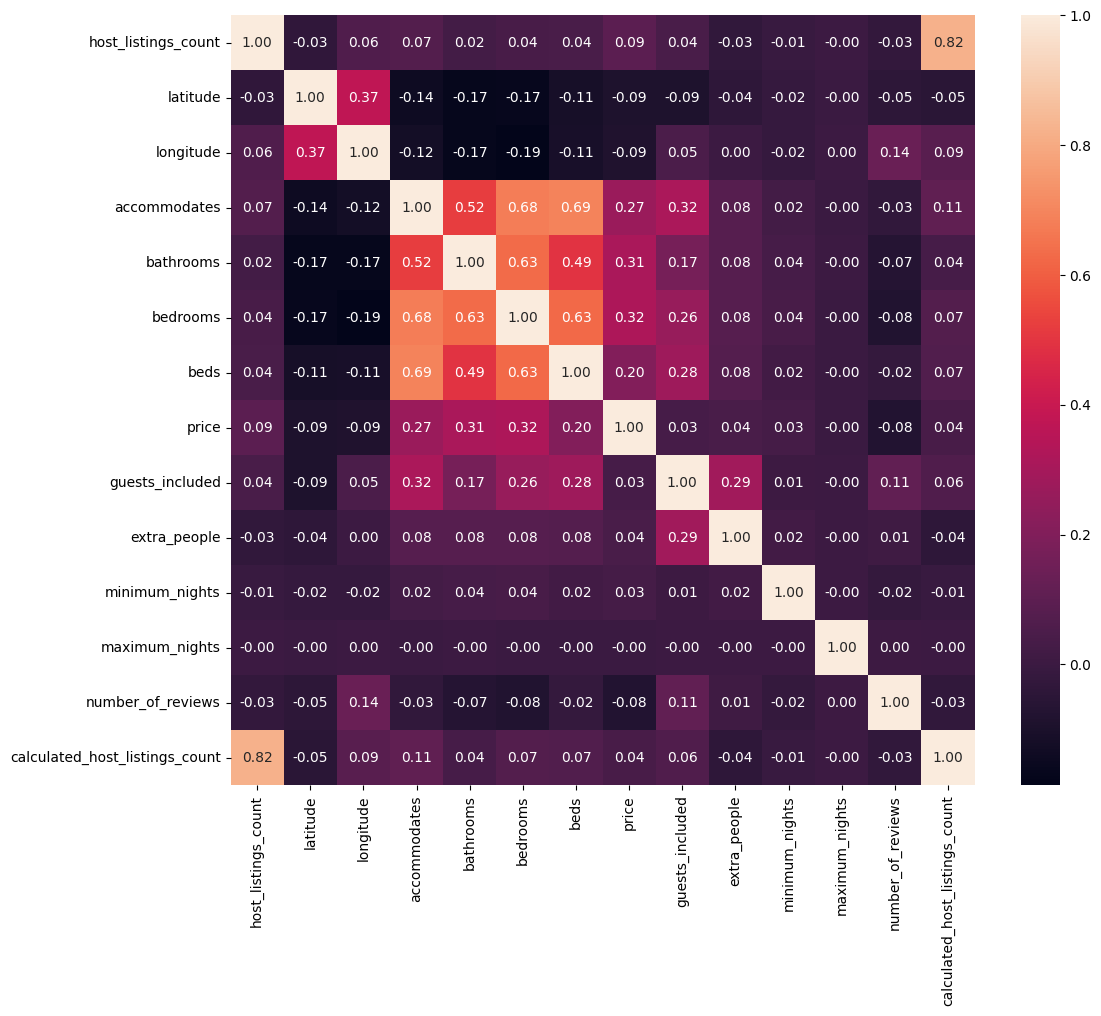

In [ ]:
# Verificando a correlação entre os dados utilizando o heatmap

# Selecionando apenas as colunas numéricas
numerical_df = base_airbnb.select_dtypes(include=['number'])

# Ajustar o tamanho da figura
plt.figure(figsize=(12, 10))

# Verificando a correlação entre os dados utilizando o heatmap
sns.heatmap(numerical_df.corr(), fmt=".2f", annot=True)
plt.show()

### Definição de Funções para Análise de Outliers

Vamos definir algumas funções para ajudar na análise de outliers das colunas

### price

Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão apenas de apartamentos de altíssimo luxo, que não é o nosso objetivo principal. Por isso, podemos excluir esses outliers.

In [ ]:
# Calcule o primeiro e terceiro quartis
Q1 = base_airbnb['price'].quantile(0.25)
Q3 = base_airbnb['price'].quantile(0.75)
IQR = Q3 - Q1

# Defina os limites
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


print(limite_inferior)
print(limite_superior)

base_airbnb = base_airbnb[(base_airbnb['price'] >= limite_inferior) &
                     (base_airbnb['price'] <= limite_superior)]

-524.0
1276.0


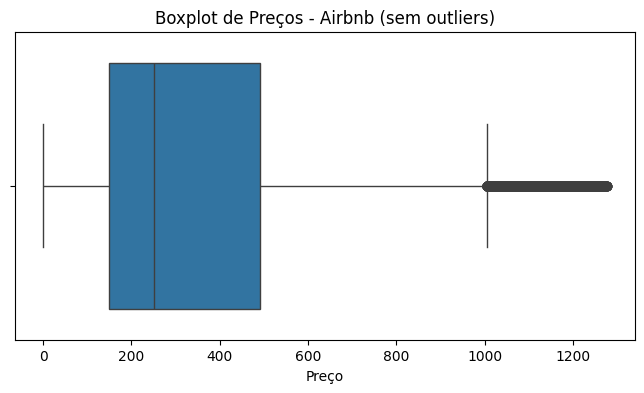

In [ ]:
#Box Plot price
plt.figure(figsize=(8, 4))
sns.boxplot(x=base_airbnb['price'])
plt.title('Boxplot de Preços - Airbnb (sem outliers)')
plt.xlabel('Preço')
plt.show()

### extra_people

In [ ]:
# Calcule o primeiro e terceiro quartis
Q1 = base_airbnb['extra_people'].quantile(0.25)
Q3 = base_airbnb['extra_people'].quantile(0.75)
IQR = Q3 - Q1

# Defina os limites

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


print(limite_inferior)
print(limite_superior)

base_airbnb = base_airbnb[(base_airbnb['extra_people'] >= limite_inferior) &
                     (base_airbnb['extra_people'] <= limite_superior)]

-75.0
125.0


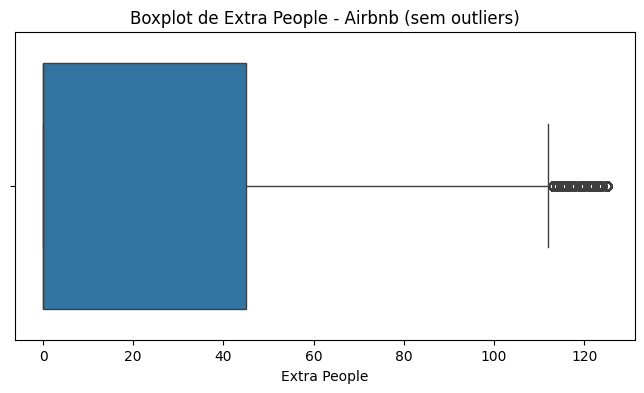

In [ ]:
#Box Plot extra_people
plt.figure(figsize=(8, 4))
sns.boxplot(x=base_airbnb['extra_people'])
plt.title('Boxplot de Extra People - Airbnb (sem outliers)')
plt.xlabel('Extra People')
plt.show()

### host_listings_count

Podemos excluir os outliers, porque para o objetivo do nosso projeto porque hosts com mais de 6 imóveis no airbnb não é o público alvo do objetivo do projeto (imagino que sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [ ]:
# Calcule o primeiro e terceiro quartis
Q1 = base_airbnb['host_listings_count'].quantile(0.25)
Q3 = base_airbnb['host_listings_count'].quantile(0.75)
IQR = Q3 - Q1

# Defina os limites
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


print(limite_inferior)
print(limite_superior)

base_airbnb = base_airbnb[(base_airbnb['host_listings_count'] >= limite_inferior) &
                     (base_airbnb['host_listings_count'] <= limite_superior)]



-2.0
6.0


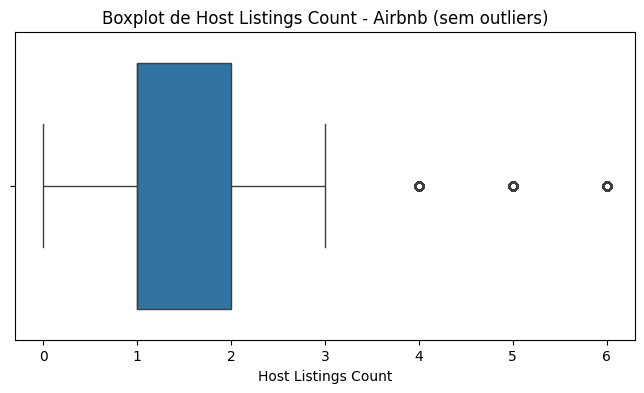

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=base_airbnb['host_listings_count'])
plt.title('Boxplot de Host Listings Count - Airbnb (sem outliers)')
plt.xlabel('Host Listings Count')
plt.show()

### accommodates

- Pelo mesmo motivo do "host_listings_count" vamos excluir os outliers dessa coluna porque apartamentos que acomodam mais de 9 pessoas não são o nosso foco, nosso objetivo aqui é para imóveis comuns.

- Caso a gente quisesse incluir apartamentos de alto padrão a gente poderia manter essa variável ou então construir um modelo só focado em imóvei com mais de 9 hóspedes

In [ ]:
# Calcule o primeiro e terceiro quartis
Q1 = base_airbnb['accommodates'].quantile(0.25)
Q3 = base_airbnb['accommodates'].quantile(0.75)
IQR = Q3 - Q1

# Defina os limites
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


print(limite_inferior)
print(limite_superior)

base_airbnb = base_airbnb[(base_airbnb['accommodates'] >= limite_inferior) &
                     (base_airbnb['accommodates'] <= limite_superior)]



-2.5
9.5


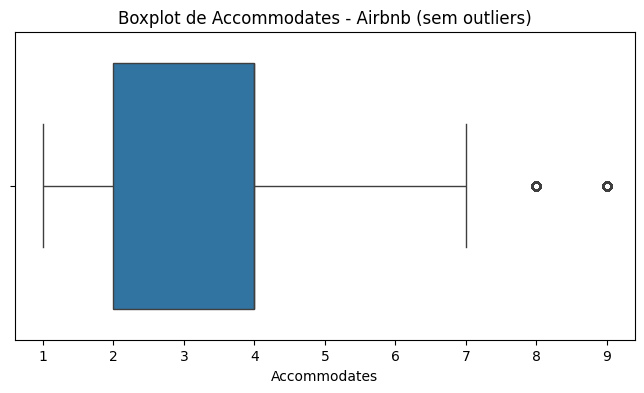

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=base_airbnb['accommodates'])
plt.title('Boxplot de Accommodates - Airbnb (sem outliers)')
plt.xlabel('Accommodates')
plt.show()

### bathrooms

- Pelo mesmo motivo dos anteriores, vamos excluir os outliers nos banheiros

In [ ]:
# Calcule o primeiro e terceiro quartis
Q1 = base_airbnb['bathrooms'].quantile(0.25)
Q3 = base_airbnb['bathrooms'].quantile(0.75)
IQR = Q3 - Q1

# Defina os limites
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


print(limite_inferior)
print(limite_superior)

base_airbnb = base_airbnb[(base_airbnb['bathrooms'] >= limite_inferior) &
                     (base_airbnb['bathrooms'] <= limite_superior)]


-0.5
3.5


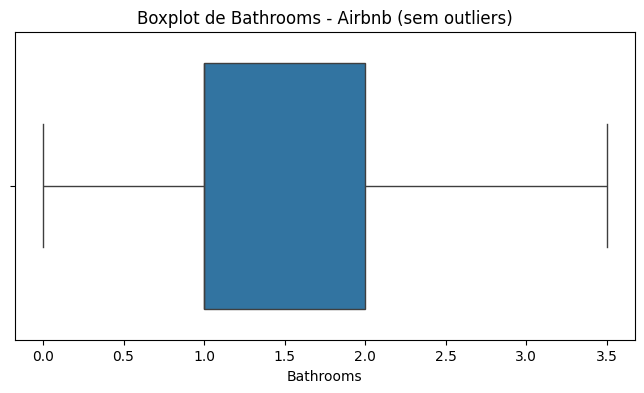

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=base_airbnb['bathrooms'])
plt.title('Boxplot de Bathrooms - Airbnb (sem outliers)')
plt.xlabel('Bathrooms')
plt.show()


### bedrooms

- Pelo mesmo motivo dos anteriores, vamos excluir outliers em quantidade de quartos

In [ ]:
# Calcule o primeiro e terceiro quartis
Q1 = base_airbnb['bedrooms'].quantile(0.25)
Q3 = base_airbnb['bedrooms'].quantile(0.75)
IQR = Q3 - Q1

# Defina os limites
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


print(limite_inferior)
print(limite_superior)

base_airbnb = base_airbnb[(base_airbnb['bedrooms'] >= limite_inferior) &
                     (base_airbnb['bedrooms'] <= limite_superior)]

-0.5
3.5


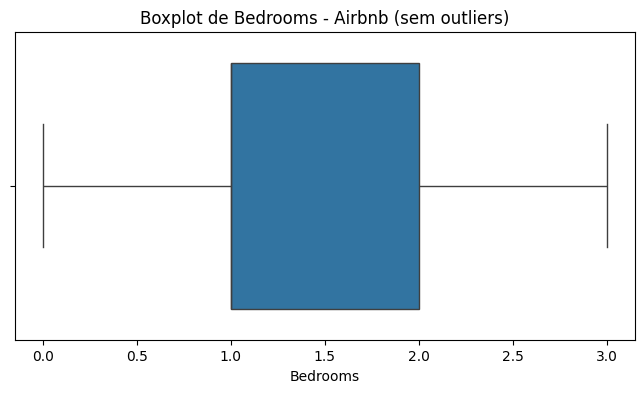

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=base_airbnb['bedrooms'])
plt.title('Boxplot de Bedrooms - Airbnb (sem outliers)')
plt.xlabel('Bedrooms')
plt.show()


- Pelo mesmo motivo dos anteriores, vamos excluir outliers em quantidade de camas

In [ ]:
# Calcule o primeiro e terceiro quartis
Q1 = base_airbnb['beds'].quantile(0.25)
Q3 = base_airbnb['beds'].quantile(0.75)
IQR = Q3 - Q1

# Defina os limites
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


print(limite_inferior)
print(limite_superior)

base_airbnb = base_airbnb[(base_airbnb['beds'] >= limite_inferior) &
                     (base_airbnb['beds'] <= limite_superior)]

-2.0
6.0


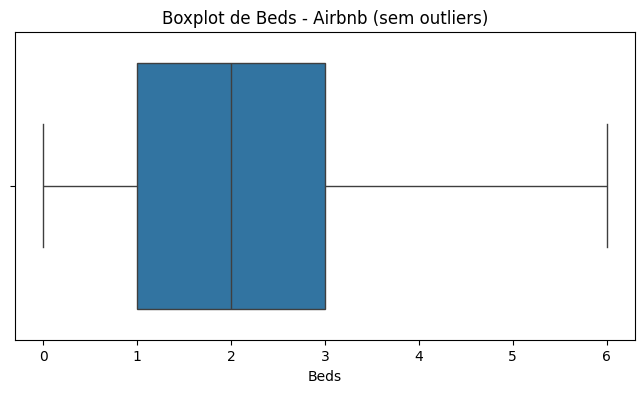

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=base_airbnb['beds'])
plt.title('Boxplot de Beds - Airbnb (sem outliers)')
plt.xlabel('Beds')
plt.show()


Vamos remover essa feature da análise. Parece que os usuários do airbnb usam muito o valor padrão do airbnb como 1 guest included. Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço, por isso, me parece melhor excluir a coluna da análise

In [ ]:
base_airbnb = base_airbnb.drop(['beds'], axis=1)

### minimum_nights

- Aqui temos um motivo talvez até mais forte para excluir esses apartamentos da análise.

- Estamos querendo um modelo que ajude a precificar apartamentos comuns como uma pessoa comum gostaria de disponibilizar. No caso, apartamentos com mais de 8 noites como o "mínimo de noites" podem ser apartamentos de temporada ou ainda apartamentos para morar, em que o host exige pelo menos 1 mês no apartamento.

- Por isso, vamos excluir os outliers dessa coluna

In [ ]:
# Calcule o primeiro e terceiro quartis
Q1 = base_airbnb['minimum_nights'].quantile(0.25)
Q3 = base_airbnb['minimum_nights'].quantile(0.75)
IQR = Q3 - Q1

# Defina os limites
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


print(limite_inferior)
print(limite_superior)

base_airbnb = base_airbnb[(base_airbnb['minimum_nights'] >= limite_inferior) &
                     (base_airbnb['minimum_nights'] <= limite_superior)]

-3.5
8.5


### maximum_nights

- Essa coluna não parece que vai ajudar na análise.

- Isso porque parece que quase todos os hosts não preenchem esse campo de maximum nights, então ele não parece que vai ser um fator relevante.

- É melhor excluirmos essa coluna da análise

In [ ]:
base_airbnb = base_airbnb.drop(['maximum_nights'], axis=1)

In [ ]:
base_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 581983 entries, 1 to 902209
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   host_listings_count             581983 non-null  float64
 1   latitude                        581983 non-null  float64
 2   longitude                       581983 non-null  float64
 3   property_type                   581983 non-null  object 
 4   room_type                       581983 non-null  object 
 5   accommodates                    581983 non-null  int64  
 6   bathrooms                       581983 non-null  float64
 7   bedrooms                        581983 non-null  float64
 8   bed_type                        581983 non-null  object 
 9   price                           581983 non-null  float64
 10  guests_included                 581983 non-null  int64  
 11  extra_people                    581983 non-null  float64
 12  minimum_nights       

### number_of_reviews            

- Aqui poderíamos tomar algumas decisões diferentes. Eu vou tomar uma decisão baseado na minha análise pessoal de tirar essa característica da análise, por alguns motivos:

    1. Se excluirmos os outliers, vamos excluir as pessoas que tem a maior quantidade de reviews (o que normalmente são os hosts que têm mais aluguel). Isso pode impactar muito negativamente o nosso modelo
    2. Pensando no nosso objetivo, se eu tenho um imóvel parado e quero colocar meu imóvel lá, é claro que eu não tenho review nenhuma. Então talvez tirar essa característica da análise pode na verdade acabar ajudando.
    3. Particularmente tenho dúvida se essa característica deveria impactar ou não o preço final

In [ ]:
base_airbnb = base_airbnb.drop(['number_of_reviews'], axis=1)

### Tratamento de Colunas de Valores de Texto

In [ ]:
# Inicialize o encoder
label_encoder = LabelEncoder()

### - property_type

In [ ]:
base_airbnb['property_type'] = label_encoder.fit_transform(base_airbnb['property_type'])

### - room_type

In [ ]:
base_airbnb['room_type'] = label_encoder.fit_transform(base_airbnb['room_type'])

### - bed_type

In [ ]:
base_airbnb['bed_type'] = label_encoder.fit_transform(base_airbnb['bed_type'])

### - month

In [ ]:
base_airbnb['month'] = label_encoder.fit_transform(base_airbnb['month'])

### - year

In [ ]:
base_airbnb['year'] = label_encoder.fit_transform(base_airbnb['year'])

In [ ]:
# Verificando a cardinalidade da base
print(base_airbnb.nunique())

host_listings_count                   7
latitude                          47567
longitude                         50975
property_type                        47
room_type                             4
accommodates                          9
bathrooms                             8
bedrooms                              4
bed_type                              5
price                              1248
guests_included                      15
extra_people                        115
minimum_nights                        8
calculated_host_listings_count       21
month                                12
year                                  3
dtype: int64


In [ ]:
base_airbnb = base_airbnb.drop(['calculated_host_listings_count', 'host_listings_count'], axis=1)


In [ ]:
base_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 581983 entries, 1 to 902209
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   latitude         581983 non-null  float64
 1   longitude        581983 non-null  float64
 2   property_type    581983 non-null  int64  
 3   room_type        581983 non-null  int64  
 4   accommodates     581983 non-null  int64  
 5   bathrooms        581983 non-null  float64
 6   bedrooms         581983 non-null  float64
 7   bed_type         581983 non-null  int64  
 8   price            581983 non-null  float64
 9   guests_included  581983 non-null  int64  
 10  extra_people     581983 non-null  float64
 11  minimum_nights   581983 non-null  int64  
 12  month            581983 non-null  int64  
 13  year             581983 non-null  int64  
dtypes: float64(6), int64(8)
memory usage: 66.6 MB


### Modelo de Previsão

- Métricas de Avaliação

Vamos usar aqui o R² que vai nos dizer o quão bem o nosso modelo consegue explicar o preço. Isso seria um ótimo parâmetro para ver o quão bom é nosso modelo <br>
-> Quanto mais próximo de 100%, melhor

Calcular também o Erro Quadrático Médio, que vai mostrar para gente o quanto o nosso modelo está errando. <br>
-> Quanto menor for o erro, melhor

- Escolha dos Modelos a Serem Testados
    1. RandomForest
    2. LinearRegression
    3. Extra Tree
    
Esses são alguns dos modelos que existem para fazer previsão de valores numéricos (o que chamamos de regressão). Estamos querendo calcular o preço, portanto, queremos prever um valor numérico.

Assim, escolhemos esses 3 modelos. Existem dezenas, ou até centenas de modelos diferentes. A medida com que você for aprendendo mais e mais sobre Ciência de Dados, você vai aprender sempre novos modelos e entendendo aos poucos qual o melhor modelo para usar em cada situação.

Mas na dúvida, esses 3 modelos que usamos aqui são bem bons para muitos problemas de Regressão.

- Separa os dados em treino e teste + Treino do Modelo

Essa etapa é crucial. As Inteligências Artificiais aprendendo com o que chamamos de treino.

Basicamente o que a gente faz é: a gente separa as informações em treino e teste, ex: 10% da base de dados vai servir para teste e 90% para treino (normalmente treino é maior mesmo)

Aí, damos para o modelo os dados de treino, ele vai olhar aqueles dados e aprender a prever os preços.

Depois que ele aprende, você faz um teste com ele, com os dados de teste, para ver se ela está bom ou não. Analisando os dados de teste você descobre o melhor modelo

In [ ]:
x = base_airbnb.drop('price',axis=1)
y = base_airbnb.price

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.10, random_state=42)

In [ ]:
from sklearn.metrics import r2_score

# Criando e treinando o modelo
model = LinearRegression()
model.fit(X_train, Y_train)

# Fazendo previsões
y_pred = model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(Y_test, y_pred)

r2 = r2_score(Y_test, y_pred)
# Exibindo parâmetros do modelo

In [ ]:
print(f"Mean Squared Error: {mse:.2f}")
print(f"Regressão Linear por - R² Score: {r2:.2f}")

Mean Squared Error: 48835.20
Regressão Linear por - R² Score: 0.29


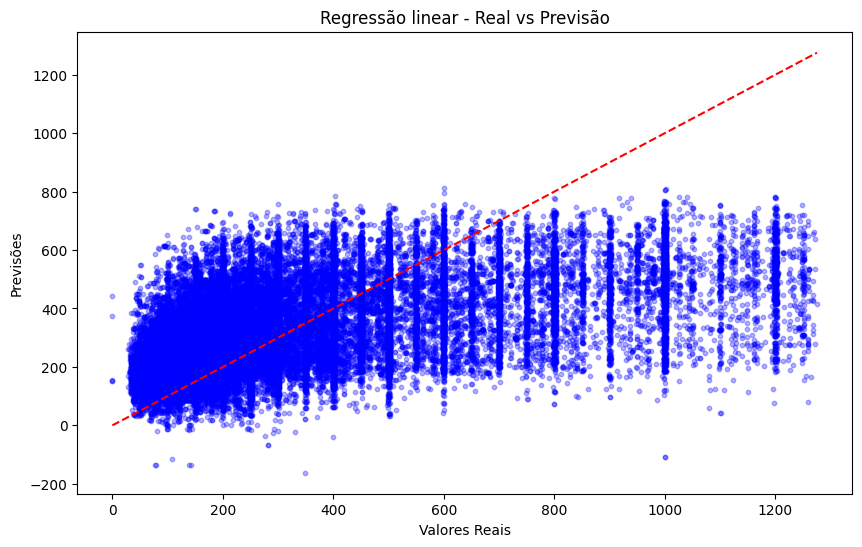

In [ ]:
# Gráfico de dispersão das previsões do Linear Regression

plt.figure(figsize=(10, 6))
plt.scatter(Y_test, y_pred, alpha=0.3, s=10, c='blue')  # Alterações: alpha=0.3, s=10
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--')
plt.title('Regressão linear - Real vs Previsão')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.show()


### Random Forest

In [ ]:
# Random Forest Classifier
rf_classifier = RandomForestRegressor(max_depth= 50, n_estimators= 100, n_jobs=-1)
rf_classifier.fit(X_train, Y_train)
rf_predictions = rf_classifier.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(Y_test, rf_predictions)
r2 = r2_score(Y_test, rf_predictions)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")
# Regressão Linear

n = X_test.shape[0]
p = X_test.shape[1]

# Calculando o R² ajustado
r2_ajustado = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"R² Ajustado: {r2_ajustado:.4f}")

Mean Squared Error: 1848.69
R² Score: 0.97
R² Ajustado: 0.9731


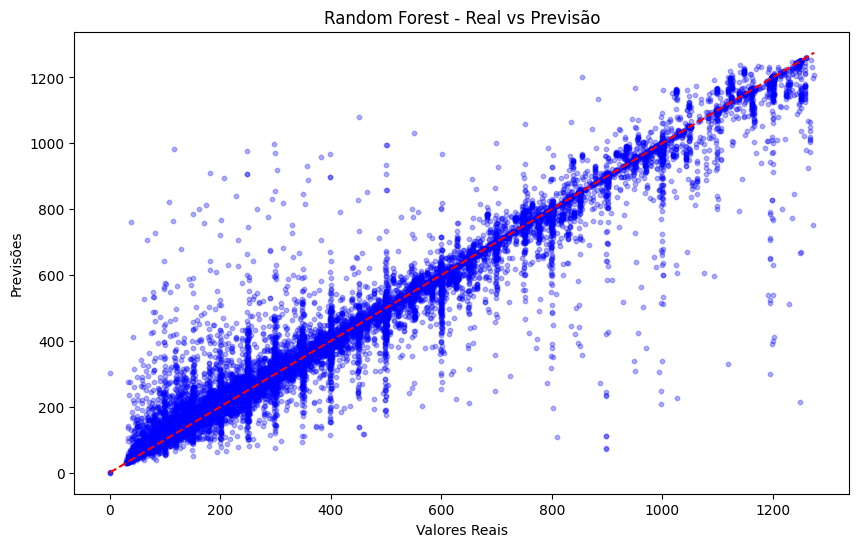

In [ ]:
# Gráfico de dispersão das previsões do Random Forest

plt.figure(figsize=(10, 6))
plt.scatter(Y_test, rf_predictions, alpha=0.3, s=10, c='blue')  # Alterações: alpha=0.3, s=10
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--')
plt.title('Random Forest - Real vs Previsão')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.show()


### ExtraTrees

In [ ]:
# Extra Trees Classifier
et_classifier = ExtraTreesRegressor(n_estimators=100, max_depth=50, n_jobs=-1)
et_classifier.fit(X_train, Y_train)
et_predictions = et_classifier.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(Y_test, et_predictions)
r2 = r2_score(Y_test, et_predictions)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")
# Regressão Linear

n = X_test.shape[0]
p = X_test.shape[1]

# Calculando o R² ajustado
r2_ajustado = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"R² Ajustado: {r2_ajustado:.4f}")

Mean Squared Error: 1899.17
R² Score: 0.97
R² Ajustado: 0.9724


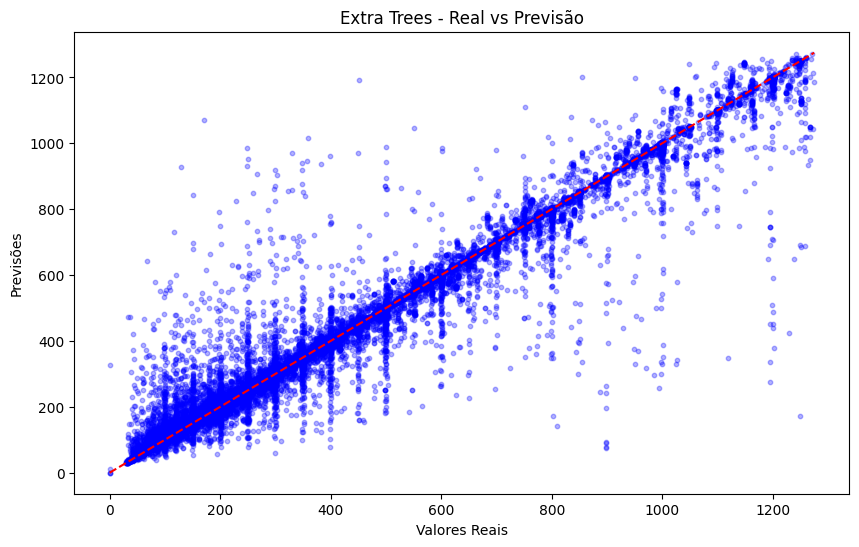

In [ ]:
# Gráfico de dispersão das previsões do Random Forest

plt.figure(figsize=(10, 6))
plt.scatter(Y_test, et_predictions, alpha=0.3, s=10, c='blue')  # Alterações: alpha=0.3, s=10
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--')
plt.title('Extra Trees - Real vs Previsão')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.show()


### Análise do Melhor Modelo

- Modelo Escolhido como Melhor Modelo: Random Forest
   
- Resultados das Métricas de Avaliação no Modelo Vencedor:<br>
<strong>Mean Squared Error: 38630.10</strong><br>
<strong>R² Score: 0.44</strong><br>
<strong>R² Ajustado: 0.4382</strong>





### Ajustes e Melhorias no Melhor Modelo

### Fazendo o tuning com KFold e GridSearchCV

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Usando KFold
kf = KFold(shuffle=True, random_state=42)


# Criando o modelo RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1)

# Definindo o grid de hiperparâmetros para busca
param_grid = {
    'n_estimators': [50, 100],           # Número de árvores na floresta
    'max_depth': [50, 100],                # Profundidade máxima das árvores
    'min_samples_split': [2, 5],                # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2],                  # Número mínimo de amostras em um nó folha
    'max_features': ['sqrt', 'log2']       # Número máximo de características a considerar
}


# Configurando a busca de hiperparâmetros com validação cruzada
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=kf,
                           n_jobs=-1,                 # Usa todos os núcleos disponíveis
                           verbose=2)                 # Verbosidade para ver o progresso

# Treinando o modelo
grid_search.fit(X_train, Y_train)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

# Fazendo previsões
y_pred = best_model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mean Squared Error: 5399.20
R² Score: 0.92
Best Parameters: {'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
